# Bahdanau 注意力



In [1]:
import sys
sys.path.append('..')

In [2]:
from d2l import mindspore as d2l
import mindspore
from mindspore import nn

带有注意力机制的解码器基本接口

In [ ]:
#@save
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

实现带有Bahdanau注意力的循环神经网络解码器

In [3]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0., **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = d2l.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = d2l.Dense(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.transpose(1, 0, 2), hidden_state, enc_valid_lens)

    def construct(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size,
        # num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).transpose(1, 0, 2)
        outputs, self._attention_weights = [], []
        for i in range(X.shape[0]):
            x = X[i]
            # query的形状为(batch_size,1,num_hiddens)
            query = d2l.expand_dims(hidden_state[-1], axis=1)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = d2l.concat((context, d2l.expand_dims(x, axis=1)), axis=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.transpose(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        outputs = self.dense(d2l.concat(outputs, axis=0))
        return outputs.transpose(1, 0, 2), (enc_outputs, hidden_state,
                                          enc_valid_lens)

    @property
    def attention_weights(self):
        return self._attention_weights

测试Bahdanau注意力解码器

In [4]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.set_train(False)
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.set_train(False)
X = d2l.zeros((4, 7), dtype=mindspore.int32)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

((4, 7, 10), 2, (4, 7, 16), 2, (4, 16))

训练

In [5]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)

将几个英语句子翻译成法语

loss 0.018, 4419.3 tokens/sec


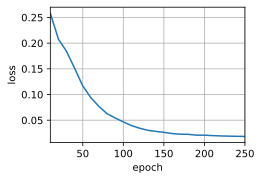

In [6]:
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [7]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est riche .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [8]:
attention_weights = d2l.reshape(
    d2l.concat([step[0][0][0] for step in dec_attention_weight_seq], 0),
    (1, 1, -1, num_steps))

可视化注意力权重

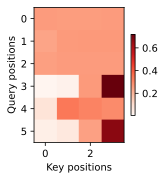

In [9]:
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1],
    xlabel='Key positions', ylabel='Query positions')